/var/folders/s6/4wdnb9rx1cl3r28sklncyvs00000gs/T/ipykernel_11261/66923191.py:12: RuntimeWarning: divide by zero encountered in log10
  HyMAG=np.array([np.log10(np.linalg.norm(ii)) for ii in Hy])


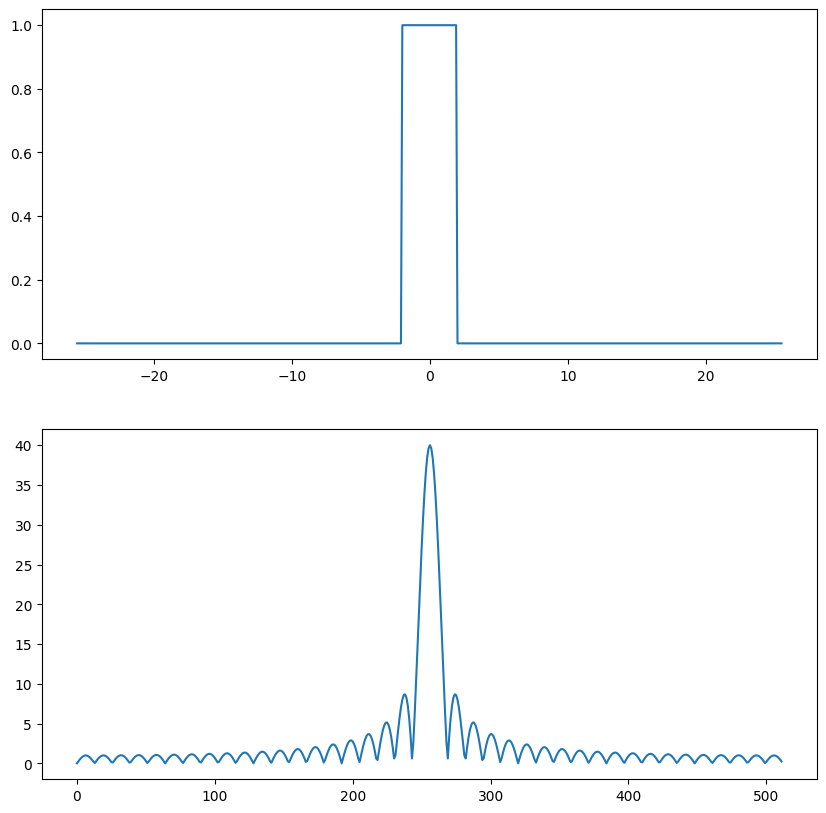

In [215]:
#plot 1D Sky View function and its fft (which is the interference pattern)
#
# 
import numpy as np
from matplotlib import pyplot as plt
x=np.arange(-25.6,25.6,0.1,dtype=float)
y=np.zeros(512)+1e-15
y[np.abs(x)<2.0]=1.0
fig,ax=plt.subplots(2,1,figsize=(10,10))
ax[0].plot(x,y)
Hy=np.fft.fftshift(np.fft.fft(np.fft.ifftshift(y)))
HyMAG=np.array([np.log10(np.linalg.norm(ii)) for ii in Hy])
HyMAG=np.array([np.linalg.norm(ii) for ii in Hy])
#HyMAG=np.array([np.linalg.norm(ii) for ii in Hy])
ax[1].plot(HyMAG)



Text(0.5, 1.0, 'backGround')

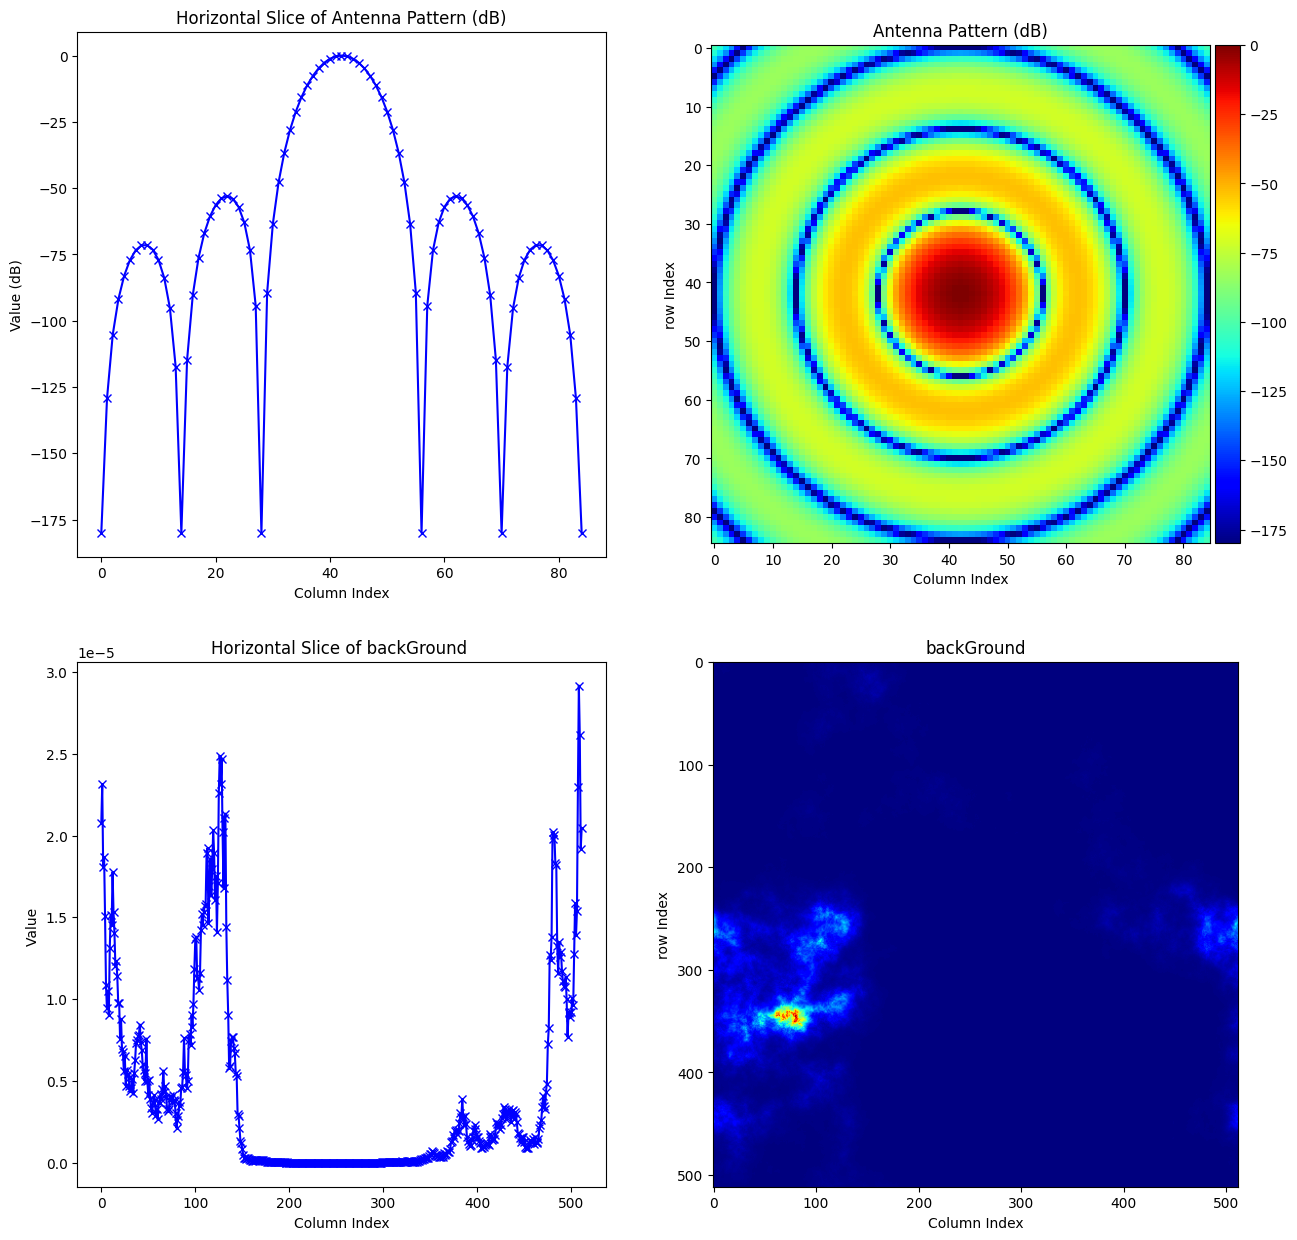

In [313]:
from diamondSquare import make_terrain,single_diamond_square_step,periodic,fixed

import random

random.seed(1)

def normalize_2d(matrix):
    norm = np.linalg.norm(matrix)
    matrix = matrix/norm  # normalized matrix
    return matrix

def generate_sinc_kernel(size, sigma):
    kernel = np.zeros((size, size))
    center = size // 2
    for i in range(size):
        for j in range(size):
            x = i - center
            y = j - center
            distance = np.sqrt(x**2 + y**2)
            kernel[i, j] = (np.sinc(distance / sigma)**2)**2+1e-9
    return kernel

#######
# create an array that tapers the edges of the sampling pattern
#######
def create_gaussian_taper(M, N, sigma):
    # Create a meshgrid of indices
    x = np.arange(N) - (N - 1) / 2
    y = np.arange(M) - (M - 1) / 2
    xx, yy = np.meshgrid(x, y)
    
    # Calculate the distance from the center of the image
    distance = np.sqrt(xx**2 + yy**2)
    
    # Calculate the Gaussian taper
    taper = np.exp(-0.5 * (distance / sigma)**2)
    
    return taper

# Example usage
kernel_size = 85
sigma = 14.0
antenna_kernel = generate_sinc_kernel(kernel_size, sigma)

n = 1 + 2**9  # Edge size of the resulting image in pixes
ds = 0.6  # Roughness delta, 0 < ds < 1 : smaller ds => smoother results
bdry = periodic  # One of the averaging routines: fixed or periodic

backGround = np.power(10,-6+4*make_terrain(n, ds, bdry)[:512,:512])

# Choose the row index for the horizontal slice
row_index = antenna_kernel.shape[0] // 2

# Get the horizontal slice from the array
horizontal_slice = antenna_kernel[row_index, :]

fig,ax=plt.subplots(2,2,figsize=(15,15))
imSlice=ax[0][0].plot(20*np.log10(horizontal_slice),'bx-')
ax[0][0].set_xlabel('Column Index')
ax[0][0].set_ylabel('Value (dB)')
ax[0][0].set_title('Horizontal Slice of Antenna Pattern (dB)')

imKernel=ax[0][1].imshow(20*np.log10(antenna_kernel), cmap='jet')
ax[0][1].set_xlabel('Column Index')
ax[0][1].set_ylabel('row Index')
ax[0][1].set_title('Antenna Pattern (dB)')
divider = make_axes_locatable(ax[0][1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(imKernel, cax=cax, orientation='vertical')

imHMslice=ax[1][0].plot(backGround[backGround.shape[0]//2, :],'bx-')
ax[1][0].set_xlabel('Column Index')
ax[1][0].set_ylabel('Value ')
ax[1][0].set_title('Horizontal Slice of backGround ')

imHM=ax[1][1].imshow(np.power(10,backGround / 10), cmap='jet')
ax[1][1].set_xlabel('Column Index')
ax[1][1].set_ylabel('row Index')
ax[1][1].set_title('backGround')



In [249]:
import pandas as pd

# Read the Excel file into a dataframe
df = pd.read_excel('starMap.xlsx', sheet_name='starData',index_col='Names')

# Display the dataframe
df

,X,Y,R,RA,DEC,Mag,Az_Deg,Alt_Deg,RA Deg,RA_rel,Dec_rel
Names,,,,,,,,,,,
Rigel (Algebar),13.00,-23.00,5,05:14:33.700000,-8.200806,0.15,217.660833,31.869389,78.640417,4.404685,-9.428171
Cursa,21.25,-15.75,5,05:07:52.300000,-5.086000,0.15,221.151111,33.835806,76.967917,6.077185,-6.313365
Lost Jewel cluster,-5.00,-13.50,5,05:36:35.200000,-5.914139,2.50,213.209611,36.161111,84.146667,-1.101565,-7.141504
Saiph,-19.00,-23.50,5,05:47:47,-9.668639,2.05,208.017639,33.841111,86.945833,-3.900732,-10.896004
Alnitak,-8.00,-4.00,5,05:40:48,-1.941778,1.85,213.713306,40.333528,85.200000,-2.154899,-3.169143
Alnilam,-3.25,-2.75,5,05:36:14.200000,-1.201167,1.65,215.475722,40.531389,84.059167,-1.014065,-2.428532
Mintaka,1.25,-0.75,5,05:32:01.800000,-0.298333,2.40,217.243806,40.884556,83.007500,0.037601,-1.525698
Saif al Jabbar,7.25,-7.25,5,05:32:01.800000,-0.298333,3.35,218.192833,38.163500,83.007500,0.037601,-1.525698
u Ori,-21.00,28.75,5,06:02:24.400000,9.647472,4.30,213.454556,53.111389,90.601667,-7.556565,8.420107


Adding: Rigel (Algebar) at 4.40,-9.43 with Mag 0.15
Adding: Cursa at 6.08,-6.31 with Mag 0.15
Adding: Lost Jewel cluster at -1.10,-7.14 with Mag 2.50
Adding: Saiph at -3.90,-10.90 with Mag 2.05
Adding: Alnitak at -2.15,-3.17 with Mag 1.85
Adding: Alnilam at -1.01,-2.43 with Mag 1.65
Adding: Mintaka at 0.04,-1.53 with Mag 2.40
Adding: Saif al Jabbar at 0.04,-1.53 with Mag 3.35
Adding: u Ori at -7.56,8.42 with Mag 4.30
Adding: Betelgeuse at -5.75,6.18 with Mag 0.45
Adding: Bellatrix at 1.76,5.12 with Mag 1.60
Adding: Tabit at 10.58,5.73 with Mag 1.60
Adding: Heka at -0.67,8.26 with Mag 4.35
Adding: Meissa at -0.75,8.71 with Mag 3.50


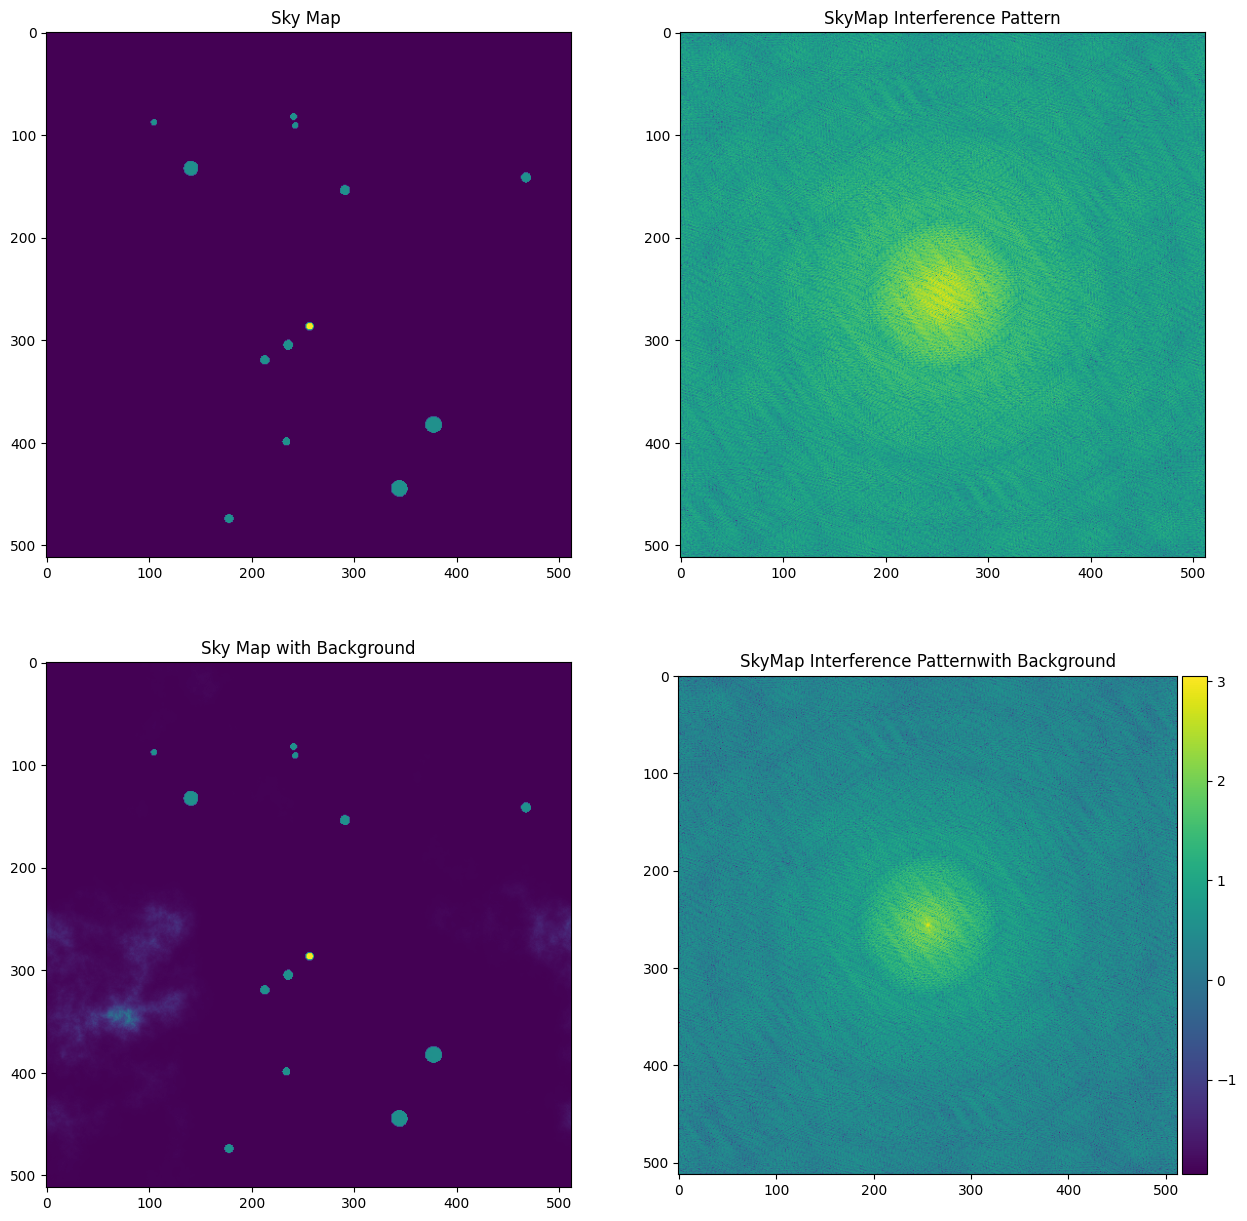

In [304]:
# Create Sky view and show FFT of sky.

from mpl_toolkits.axes_grid1 import make_axes_locatable

def calculate_2dft(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.fft2(ft)
    return np.fft.fftshift(ft)
    
def calculate_2dift(input):
    ft = np.fft.fftshift(input)
    ft = np.fft.ifft2(ft)
    return np.fft.ifftshift(ft)

stepSize=0.05

dot=lambda mx,my,s,r,o : np.array([[0. if ((x+o[0])**2+(y+o[1])**2)>(r*r) else 1. for x in np.arange(-mx,mx,s)] for y in np.arange(-my,my,s)])

#SKYMAP DOTS
yy=np.zeros((512,512))
if True:
    for vv in df.index:
        print(f"Adding: {vv} at {df.loc[vv]['RA_rel']:2.2f},{df.loc[vv]['Dec_rel']:2.2f} with Mag {df.loc[vv]['Mag']:2.2f}")
        yy=yy+dot(12.8,12.8,0.05,0.1+3.0/(3+df.loc[vv]['Mag'])**2,(-df.loc[vv]['RA_rel'],df.loc[vv]['Dec_rel']))
else:
    yy=dot(12.8,12.8,stepSize,1.5,(-11.,5.))  + \
    dot(12.8,12.8,stepSize,0.5,(3.,4.)) +  \
    dot(12.8,12.8,stepSize,0.5,(-1.,8.))+  \
    dot(12.8,12.8,stepSize, 0.5,(9.,-8.))
yyBackGround=yy+backGround[:yy.shape[0],:yy.shape[1]]*10000

Hyy=calculate_2dft(yy)
HyyMAG=np.array([[np.log10(np.linalg.norm(ii)) for ii in jj] for jj in Hyy])
HyyBackground=calculate_2dft(yyBackGround)
HyyMAGBackground=np.array([[np.log10(np.linalg.norm(ii)) for ii in jj] for jj in HyyBackground])

fig,ax=plt.subplots(2,2,figsize=(15,15))
#ax[0].imshow(yy)
im=[ax[jjj // 2][jjj % 2].imshow(data) for jjj,data in enumerate([yy,HyyMAG,yyBackGround,HyyMAGBackground])]
[ax[jjj // 2][jjj % 2].set_title(data + ("with Background" if jjj // 2 >0 else "")) for jjj,data in enumerate(["Sky Map ","SkyMap Interference Pattern"]*2)]

# plt.colorbar(im[1],ax=ax[1])
divider = make_axes_locatable(ax[1][1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im[1], cax=cax, orientation='vertical')


In [292]:
#INVERT the interference pattern back to original
if False:
    BackHyyMAG=calculate_2dift(Hyy)
    fig,ax=plt.subplots(1,2,figsize=(15,15))
    #ax[0].imshow(yy)
    im=[ax[jjj].imshow(data) for jjj,data in enumerate([HyyMAG,BackHyyMAG.real])]
    [ax[jjj].set_title(data) for jjj,data in enumerate(["SkyMap Interference Pattern","Reconstructed Sky May"])]

    # plt.colorbar(im[1],ax=ax[1])
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im[1], cax=cax, orientation='vertical')



Temperature: 300 K and Bandwidth: 1000000.0 Hz
Noise floor: -143.83 dB


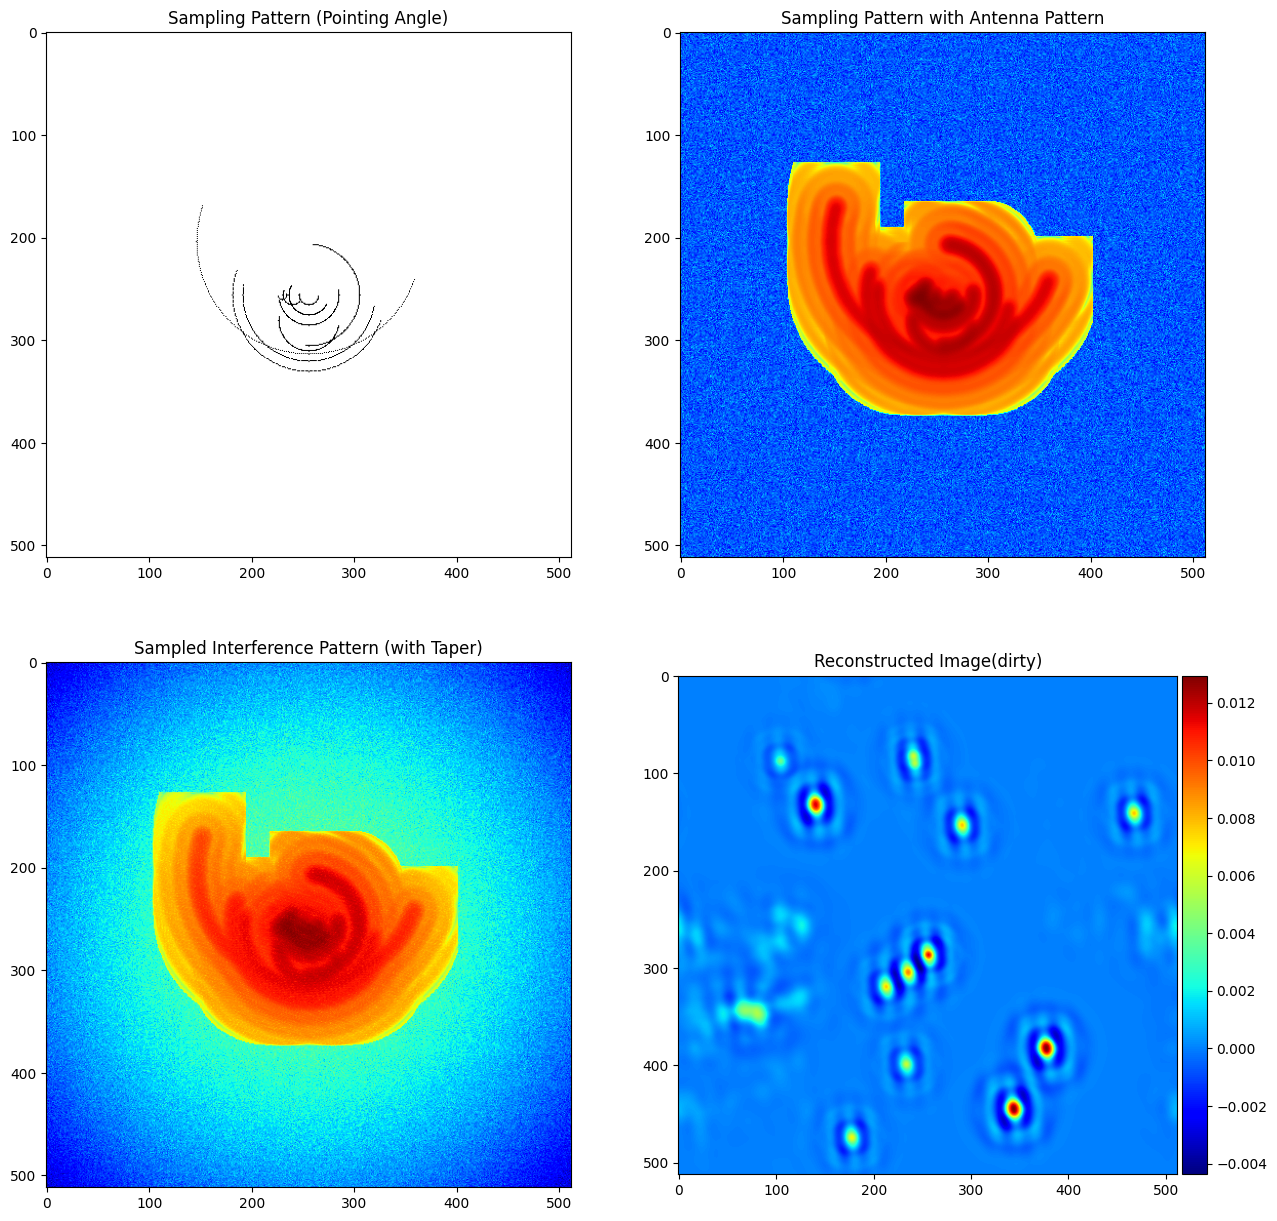

In [315]:

#implement a sampling function which samples part of the interference pattern.
#
# ifft the sampled sky view gives the dirty image of the sky 
#

if True:
    Hyy=HyyBackground
    HyyMAG=HyyMAGBackground
    yy=yyBackGround
    
rotMat = lambda rot:np.matrix([[np.cos(rot/57.295779513),-np.sin(rot/57.295779513)],[np.sin(rot/57.295779513),np.cos(rot/57.295779513)]])
rotate = lambda rot,xy:tuple((np.int16(rotMat(rot)*np.matrix(xy).transpose())).transpose().tolist()[0])
r=[(10,60,0.5,0.47),(30,80,0.55,0.5),(110,70,0.4,0.5), \
   (5,110,0.5,0.45),(20,60,0.5,0.5),(50,175,0.5,0.5),  \
     (65,80,0.5,0.5),(20,60,0.5,0.5),(75,70,0.5,0.5),   \
     (20,60,0.5,0.5),(50,175,0.5,0.5),(10,80,0.5,0.5),  \
     (20,60,0.5,0.5),(-30,280,0.5,0.5)]
# 
t=180
sample=np.zeros(Hyy.shape)+1e-15
uvPoints=np.zeros(Hyy.shape)+1e-15

#################  ADD NOISE TO THE SAMPLED POINTS
# Generate log-normal distributed noise

# calculate the mean and standard deviation of the noise floor using bolzmann's equation and the system temperature
# T = 290 K
# B = 1 Hz
# k = 1.38064852e-23 J/K
# noise_floor = k * T / B
T,B,k=300,1e6,1.38064852e-23
noise_floor = k * T * B
print("Temperature: {} K and Bandwidth: {} Hz".format(T,B))
print("Noise floor: {:.2f} dB".format(10*np.log10(noise_floor)))

Tsys = 3 #system noise in dB 

std = 3 # Standard deviation of the distribution in dB

noiseArray = np.power(10,np.random.normal(10*np.log10(noise_floor)+Tsys, 10, Hyy.shape)/10 )
sample = np.power(10,np.random.normal(10*np.log10(noise_floor)+Tsys, 10, Hyy.shape)/10 )

#First we create the skymap sampling pattern
for ll in r:
    for lll in [rotate(ll[1]-t,(ll[0],0)) for t in range(t)]:
        x,y=(int(lll[0]+len(Hyy[0])*ll[2]),int(lll[1]+len(Hyy)*ll[3]))
        uvPoints[x,y]=1.0
            # Calculate the starting indices of the kernel
        start_x = x - antenna_kernel.shape[0] // 2
        start_y = y - antenna_kernel.shape[1] // 2
        
        # Iterate over each element in the kernel
        for i in range(antenna_kernel.shape[0]):
            for j in range(antenna_kernel.shape[1]):
                # Check if the kernel element is within the buffer boundaries
                if 0 <= start_x + i < sample.shape[0] and 0 <= start_y + j < sample.shape[1]:
                    # Add the value of the kernel to the corresponding element in BUFF
                    sample[start_x + i, start_y + j] += antenna_kernel[i, j]

        #sample[int(lll[0]+len(Hyy[0])*ll[2])][int(lll[1]+len(Hyy)*ll[3])]=1.0  #Hyy[lll[0]+len(Hyy[0])//2][lll[1]+len(Hyy)//2]

sample = normalize_2d(sample)

# Create the taper
taper = create_gaussian_taper(sample.shape[0], sample.shape[1], 50)


########
# Perform the sampling of the sky map using the skymap sampling pattern
########
sampleOut = (sample*Hyy+noiseArray) * taper
########
# Perform the inverse fourier transform of the tapered sampled sky map
########
BackHyyMAG = calculate_2dift(sampleOut)

########
# Plot the results
########
fig,ax=plt.subplots(2,2,figsize=(15,15))
im=[[1,2],[0,0]]
im[0][0]=ax[0][0].imshow(uvPoints,cmap='binary')
#im[0][0]=ax[0][0].imshow(taper,cmap='jet')
im[0][1]=ax[0][1].imshow(20*np.log10(sample), cmap='jet')
#im[1][0]=ax[1][0].imshow(20*np.log10(sampleOut.imag),cmap='jet')
im[1][0]=ax[1][0].imshow(20*np.log10([[np.linalg.norm(ii) for ii in jj] for jj in sampleOut]),cmap='jet')
im[1][1]=ax[1][1].imshow(BackHyyMAG.real,cmap='jet')
[ax[1][jjj].set_title(data) for jjj,data in enumerate(["Sampled Interference Pattern (with Taper)","Reconstructed Image(dirty)"])]
[ax[0][jjj].set_title(data) for jjj,data in enumerate(["Sampling Pattern (Pointing Angle)","Sampling Pattern with Antenna Pattern"])]
# #ax[0].imshow(yy)
# im=[ax[jjj].imshow(data) for jjj,data in enumerate([sample,BackHyyMAG.real])]
# plt.colorbar(im[1],ax=ax[1])
divider = make_axes_locatable(ax[1][1])
cax = divider.append_axes('right', size='5%', pad=0.05)
_ = fig.colorbar(im[1][1], cax=cax, orientation='vertical')


In [ ]:
radiusOfSun=6.96342e5*1000  #m
lightYear=9.4607e15 #m
 